In [34]:
#CREDIT: Phil Wilkes & Kim Calders - 2020
%pylab
%matplotlib inline

Using matplotlib backend: inline
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [63]:
import pandas as pd
import os, glob, re
import open3d as o3d
import math
import matplotlib.colors as colors
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [93]:
trees = pd.read_csv('./pointcloud_print_summary.csv') 
species = list(trees.species.unique())
trees.head()

,Unnamed: 0,tree_id,species,stemlocx_.m.,stemlocky_.m.,Dead,small
0,1,CAXH1,CAXH,-3.152130,8.510615,False,False
1,2,CAXH2,CAXH,-4.904048,29.091739,False,False
2,3,CAXH3,CAXH,-11.094046,21.721499,False,False
3,4,CAXH4,CAXH,-2.933736,-4.694821,False,False
4,5,FEXC1,FEXC,-12.595647,31.380121,False,False


In [94]:
allspecies=True
flist=[]
print(len(trees.tree_id))
if allspecies:
    for i in range(0,len(trees.tree_id)): #don't do a full grab of *ply, some trees outside 1.4ha area
        flist = flist+glob.glob('./qsm_trees/*%s.ply' % trees.tree_id[i])
        flist.sort(key=lambda f: int(re.sub('\D', '', f))) #sort flists
else:
    #select one species
    onespp = trees[trees["species"] == "CAXH"].reset_index(drop=True)
    #list all the ply files of the point clouds
    for i in range(0,len(onespp.tree_id)):
        flist = flist+glob.glob('./qsm_trees/*%s.ply' % onespp.tree_id[i])
        flist.sort(key=lambda f: int(re.sub('\D', '', f))) #sort flists
print(len(flist))


160
160


In [95]:
info = pd.DataFrame(columns=['height', 'xbounds', 'ybounds'])
clda = pd.DataFrame()

for n, c in enumerate(flist):
    cloud=o3d.io.read_point_cloud(c)
    cloudname=c[:-4].split("/")[-1].split("\\")[-1]
    cld=pd.DataFrame(data=np.asarray(cloud.points),columns=['x', 'y', 'z']) #acces the points
    info.loc[cloudname, ['xbounds', 'ybounds', 'height']]=cloud.get_max_bound()-cloud.get_min_bound() #x, y and z range
    cld.loc[:, 'tree_id'] = cloudname
    clda = pd.concat([clda,cld], ignore_index=True)
    #clda = clda.append(cld)
    
print(info)
print(clda)

#https://sungchenhsi.medium.com/adding-pointcloud-to-pointcloud-9bf035707273

                    height   xbounds    ybounds
CAXH1            28.788411  17.10034  15.409101
FEXC1             22.11541   5.18147     5.5587
FSYL1             20.69506    5.2648     5.3401
LXDC1             20.34305   11.5363    9.68025
PSYLA1            18.71927   5.28259    6.39808
...                    ...       ...        ...
GUY_100_06_wood     37.458    27.716     31.118
GUY_100_08_wood     37.493    24.915     26.821
GUY_100_10_wood     42.982     22.48     21.096
GUY_100_12_wood     40.182    24.998      24.17
GUY_100_17_wood     49.128    20.222      24.46

[160 rows x 3 columns]
                x         y          z          tree_id
0        -4.66289   7.41583  23.730101            CAXH1
1        -4.63356   7.41367  23.735600            CAXH1
2        -4.62229   7.41470  23.738100            CAXH1
3        -4.68672   7.41365  23.767300            CAXH1
4        -4.66567   7.41400  23.758400            CAXH1
...           ...       ...        ...              ...
63274666

In [96]:
#add some attributes
clda = pd.merge(clda, trees[['tree_id', 'species']], on='tree_id', how='left')
# colourmap
MAP = {'CAXH':0, 'FEXC':1, 'FSYL':2, 'LXDC':3, 'PSYLA':4, 'PSYLB':5, 'r6':6, 'r7':7, 'GUY':8}
cmap = colors.ListedColormap(["#1c027a", "#04543d" , "#057354", "#08aa7c", "#0b4eba", "#3566b5", "#996212", "#fac87f", "#b4a2f5"])
boundaries = list(MAP.values())
#norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
norm = matplotlib.colors.Normalize(vmin=0, vmax=8) #range from MAP
clda.loc[:, 'rgb'] = clda.species.map(MAP)

print(clda)

                x         y          z          tree_id species  rgb
0        -4.66289   7.41583  23.730101            CAXH1    CAXH    0
1        -4.63356   7.41367  23.735600            CAXH1    CAXH    0
2        -4.62229   7.41470  23.738100            CAXH1    CAXH    0
3        -4.68672   7.41365  23.767300            CAXH1    CAXH    0
4        -4.66567   7.41400  23.758400            CAXH1    CAXH    0
...           ...       ...        ...              ...     ...  ...
63274666  4.95900  23.40700  80.664000  GUY_100_17_wood     GUY    8
63274667  4.95700  23.42700  80.653000  GUY_100_17_wood     GUY    8
63274668  4.70300  22.28100  80.683000  GUY_100_17_wood     GUY    8
63274669  4.78000  22.26000  80.683000  GUY_100_17_wood     GUY    8
63274670  4.47700  22.54500  80.678000  GUY_100_17_wood     GUY    8

[63274671 rows x 6 columns]


In [97]:
info.loc[:, 'max_w'] = info.apply(lambda r: 'x' if r.xbounds > r.ybounds else 'y', axis=1) #maxw: direction of max width
info.loc[:, 'max_wt'] = info.apply(lambda r: r.xbounds if r.xbounds > r.ybounds else r.ybounds, axis=1) #width of the max direction
info.sort_values('height', inplace=True, ascending=False)

info.head()
print(info)

                    height    xbounds    ybounds max_w     max_wt
GUY_100_17_wood     49.128     20.222      24.46     y  24.460000
GUY_80_04_wood      47.584     22.534     21.425     x  22.534000
CAXH2            45.300091  23.585649  24.004399     y  24.004399
GUY_100_10_wood     42.982      22.48     21.096     x  22.480000
GUY_80_20_wood      40.503     20.019     16.225     x  20.019000
...                    ...        ...        ...   ...        ...
r6_12               11.291      3.419      3.325     x   3.419000
r6_20c              11.276      4.226      4.077     x   4.226000
r6_80               10.098      3.001        3.7     y   3.700000
r6_19b               8.861      3.919      4.648     y   4.648000
r7_63b               8.787      2.808      2.545     x   2.808000

[160 rows x 5 columns]


In [98]:
print(info.max_wt.sum())
print(info.height.sum())

1568.21429037
3616.11101668


In [99]:
numrows=7
info.loc[:, 'Widths'] = info.max_wt.cumsum()
#numrows=math.ceil(info.max_wt.sum()*16/9) #select number of rows to get 
info.loc[:, 'Row'] = info.Widths // (info.max_wt.sum() // (numrows))  # // divide, but ignore decimals
info.iloc[-1,-1]=float(numrows)-1 #fix the last rows
info.iloc[-2,-1]=float(numrows)-1 #fix the last rows
info.iloc[-3,-1]=float(numrows)-1 #fix the last rows


print(info)

info.reset_index(inplace=True)

                    height    xbounds    ybounds max_w     max_wt  \
GUY_100_17_wood     49.128     20.222      24.46     y  24.460000   
GUY_80_04_wood      47.584     22.534     21.425     x  22.534000   
CAXH2            45.300091  23.585649  24.004399     y  24.004399   
GUY_100_10_wood     42.982      22.48     21.096     x  22.480000   
GUY_80_20_wood      40.503     20.019     16.225     x  20.019000   
...                    ...        ...        ...   ...        ...   
r6_12               11.291      3.419      3.325     x   3.419000   
r6_20c              11.276      4.226      4.077     x   4.226000   
r6_80               10.098      3.001        3.7     y   3.700000   
r6_19b               8.861      3.919      4.648     y   4.648000   
r7_63b               8.787      2.808      2.545     x   2.808000   

                      Widths  Row  
GUY_100_17_wood    24.460000  0.0  
GUY_80_04_wood     46.994000  0.0  
CAXH2              70.998399  0.0  
GUY_100_10_wood    93.47839

In [100]:
#VARIABLE HEIGHT AND WIDTH PER ROW
rh = info.groupby('Row').height.max() #relative height per row
rw = info.groupby('Row').max_wt.sum() #relative width per row
#print(rh.sum())

print(rh)
print(rw)
print(9*rh.sum()/rw.mean())

Row
0.0      49.128
1.0      37.458
2.0      26.576
3.0       23.29
4.0    21.57775
5.0      20.355
6.0    19.01765
Name: height, dtype: object
Row
0.0    205.914399
1.0    240.411830
2.0    210.083555
3.0    229.710017
4.0    225.021294
5.0    228.821655
6.0    228.251540
Name: max_wt, dtype: float64
7.930262640997745


In [101]:
legend = {'CAXH':'CAXH', 'FEXC':'FEXC', 'FSYL':'FSYL','LXDC':'LXDC','PSYLA':'PSYLA','PSYLB':'PSYLB','r6':'r6','r7':'r7','GUY':'GUY'}

/tmp/ipykernel_2097696/2462564941.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, tree in  tqdm(enumerate(info[info.Row == R].itertuples())):


0it [00:00, ?it/s]

/tmp/ipykernel_2097696/2462564941.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cld.x = cld.x - cld.x.mean() #to centre around x=0
/tmp/ipykernel_2097696/2462564941.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cld.z = cld.z - cld.z.min() #to have z from 0 to tree height
/tmp/ipykernel_2097696/2462564941.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

0it [00:00, ?it/s]

/tmp/ipykernel_2097696/2462564941.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cld.x = cld.x - cld.x.mean() #to centre around x=0
/tmp/ipykernel_2097696/2462564941.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cld.z = cld.z - cld.z.min() #to have z from 0 to tree height
/tmp/ipykernel_2097696/2462564941.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

0it [00:00, ?it/s]

/tmp/ipykernel_2097696/2462564941.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cld.x = cld.x - cld.x.mean() #to centre around x=0
/tmp/ipykernel_2097696/2462564941.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cld.z = cld.z - cld.z.min() #to have z from 0 to tree height
/tmp/ipykernel_2097696/2462564941.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

0it [00:00, ?it/s]

/tmp/ipykernel_2097696/2462564941.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cld.x = cld.x - cld.x.mean() #to centre around x=0
/tmp/ipykernel_2097696/2462564941.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cld.z = cld.z - cld.z.min() #to have z from 0 to tree height
/tmp/ipykernel_2097696/2462564941.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

0it [00:00, ?it/s]

/tmp/ipykernel_2097696/2462564941.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cld.x = cld.x - cld.x.mean() #to centre around x=0
/tmp/ipykernel_2097696/2462564941.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cld.z = cld.z - cld.z.min() #to have z from 0 to tree height
/tmp/ipykernel_2097696/2462564941.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

0it [00:00, ?it/s]

/tmp/ipykernel_2097696/2462564941.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cld.x = cld.x - cld.x.mean() #to centre around x=0
/tmp/ipykernel_2097696/2462564941.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cld.z = cld.z - cld.z.min() #to have z from 0 to tree height
/tmp/ipykernel_2097696/2462564941.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

0it [00:00, ?it/s]

/tmp/ipykernel_2097696/2462564941.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cld.x = cld.x - cld.x.mean() #to centre around x=0
/tmp/ipykernel_2097696/2462564941.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cld.z = cld.z - cld.z.min() #to have z from 0 to tree height
/tmp/ipykernel_2097696/2462564941.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

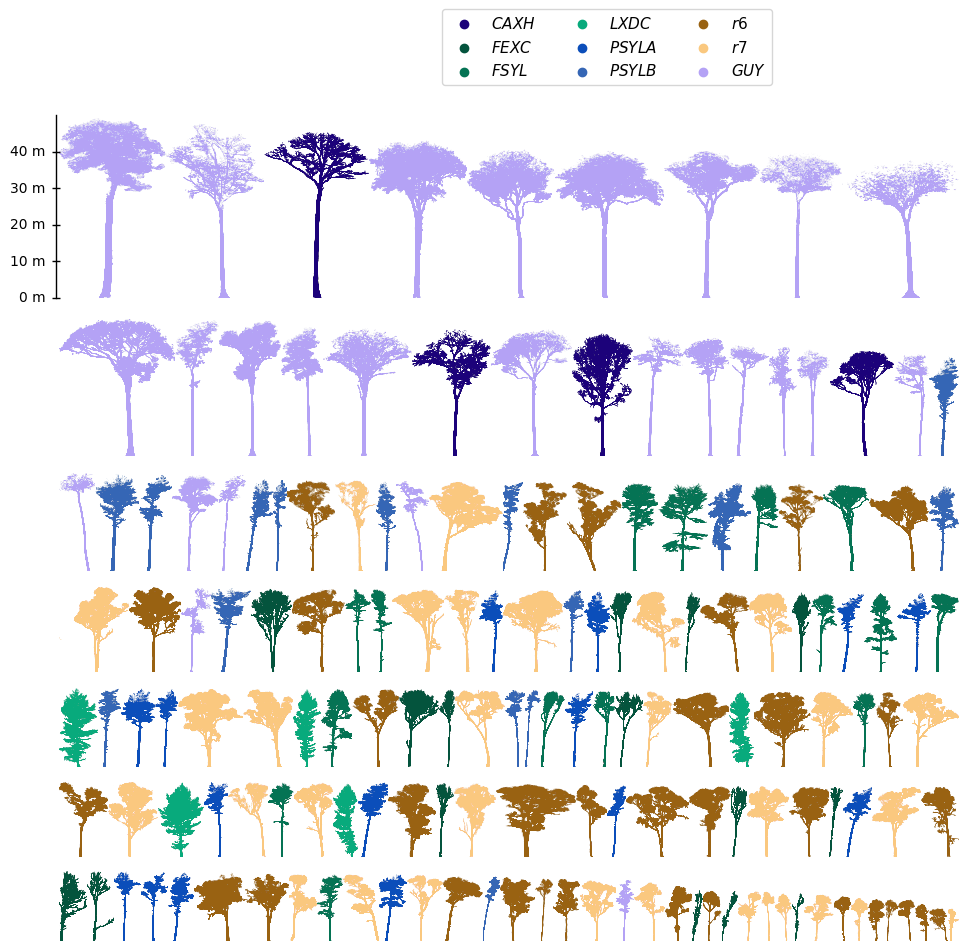

In [102]:
#XZ plot
figw=9 #w in inches
f = plt.figure(figsize=(figw, figw*rh.sum()/rw.mean())) #wxh in inches
RB = 0

for R in range(0,numrows): #loop over rows
#for R in range(2,3): 
    rb = rh[R] / rh.sum() #relative row height
    RB += rb + .01
    width_sum = info.loc[info.Row == R].max_wt.sum() #widthsum per row
    zmax = info.loc[info.Row == R].height.max()
    wmax = info.loc[info.Row == R].xbounds.max() / 2
            
    for i, tree in  tqdm(enumerate(info[info.Row == R].itertuples())):
        width_left = info.loc[info.index >= tree.Index].loc[info.Row == R].max_wt.sum() #the width we need from the common y axis on the left
#       print([1 - (width_left / width_sum), 1 - RB,  tree.max_wt / width_sum, rb])
        # The dimensions [left, bottom, width, height] of the new axes. All quantities are in fractions of figure width and height.
        # Therefore: width relative to 0-1 (full fig width), height as relative to overall fig
        ax = f.add_axes([1 - (width_left / width_sum), 1 - RB,  tree.max_wt / width_sum, rb])
        ax.axis('on')
        # comment end of line if drafting
        cld = clda[clda.tree_id == tree.index]#.loc[::10]  #with .loc[::10] take only 10% of pts
        cld.x = cld.x - cld.x.mean() #to centre around x=0
        cld.z = cld.z - cld.z.min() #to have z from 0 to tree height
        if allspecies:
            ax.scatter(cld.x, cld.z, marker=".", lw=0,s=0.06, c=cld.rgb, cmap=cmap, norm=norm)
#            ax.annotate(tree.index,(0,0),size=5)
        else:
            ax.scatter(cld.x, cld.z, marker=".", lw=0,s=0.5, c=cld.rgb, cmap=cmap, norm=norm)
#             ax.scatter(cld.x, cld.z, marker=".", lw=0,s=0.05, c='k')
        ax.set_xlim(cld.x.min(), cld.x.max())
        ax.set_ylim(0, zmax*1.1)
        ax.axis('off')
        
        if (i == 0 and R == 0): #put the y axis back on the left figure of the row
            Y = np.append(np.arange(0, math.ceil(rh[R]), 10), math.ceil(rh[R])) #the y locations for our ticks
#           Y = np.arange(0, math.ceil(rh[R]), 5) #the y locations for our ticks
#           X = np.zeros(len(Y)) + (cldx_overallmin * 1.1) #the x locations for our axis ticks (all the same)
            X = np.zeros(len(Y)) + (cld.x.min()*1.05) #the x locations for our axis ticks (all the same)
            ax.plot(X[:-1], Y[:-1], lw=1, marker='_', color='k', clip_on=False)
            ax.plot(X[-2:], Y[-2:], lw=1, color='k', clip_on=False)
            [ax.text(x - 2, y, '{:.0f} m'.format(y), va='center', ha='right') for x, y in zip(X[:-1], Y[:-1]) ]
            
    if R == 0:
        for k, v in MAP.items():
            ax.scatter([], [], c=cmap.colors[v], label='$\it{%s}$' % legend[k])
            ax.legend(loc=9, bbox_to_anchor=(-2,1.5), fontsize=11,ncol=3, title="",title_fontsize=20)           

In [103]:
# f.savefig('test.png', dpi=300, bbox_inches='tight')
f.savefig('pointcloud_print.png', dpi=300, bbox_inches='tight')
#f.savefig('alltrees_600dpi.png', dpi=600, bbox_inches='tight')